In [1]:
using QuantumBayesian
using PyPlot

# Single Qubit Evolution Tests

**Justin Dressel**, 12/6/2016 <br />
*Institute for Quantum Studies, Chapman University*

Benchmark various integration algorithms for a single qubit damped Rabi oscillation, for comparison with the DifferentialEquations package tested in a separate notebook.

## Basic Definitions

### Qubit Hilbert space

In [2]:
q = qubit()

QuantumBayesian.QFactor: Qubit
Dims  : 2
Ops   : "d", "y", "x", "u", "z", "i"


### Global Constants

In [3]:
Ω  = 2*π;        # Rabi frequency
τ = 3.0;         # Measurement collapse timescale
Γ = 1/(2*τ);     # Measurement dephasing rate (quantum-limited efficiency)
T = (0.0, 6*τ);  # Time duration of simulation;

dt = 1e-2;       # Simulation timestep (coarse to show method precision);

### Common Trajectory and Plotting Code

In [4]:
# Initial conditions (matrix and superket)
init = ground(q)
sinit = superket(init)

# Bloch expectation values (matrix and superket)
fs  = collect(ρ -> real(expect(ρ, q(l)))    for l in ["x","y","z"])
sfs = collect(ρ -> real(ρ ⋅ superket(q(l))) for l in ["x","y","z"])

# Trajectory and plotting function
function solve(inc, init, dt, T, fs, plot_title; readout=false, n=1)
    figure(1)
    if n==1
        out = trajectory(inc, init, (0.0, 0.1), fs..., dt=dt, points=10, verbose=false) #JIT throw-away
        @time out = trajectory(inc, init, T, fs..., dt=dt)
        plot(out[1].t,out[1],label=L"$x$",color="r")
        hold(true)
        plot(out[2].t,out[2],label=L"$y$",color="g")
        plot(out[3].t,out[3],label=L"$z$",color="b")
        hold(false)
    else
        out = ensemble(1, inc, init, (0.0, 0.1), fs..., dt=dt, points=10, verbose=false) #JIT throw-away
        @time out = ensemble(n, inc, init, T, fs..., dt=dt)
        m1 = mean(out[1]); m2 = mean(out[2]); m3 = mean(out[3]);
        s1 = std(out[1]); s2 = std(out[2]); s3 = std(out[3]);
        plot(out[1].t,m1,label=L"$x$",color="r")
        hold(true)
        plot(out[2].t,m2,label=L"$y$",color="g")
        plot(out[3].t,m3,label=L"$z$",color="b")
        fill_between(out[1].t, m1-s1, m1+s1, color="r", alpha=0.2, antialiased=true)
        fill_between(out[2].t, m2-s2, m2+s2, color="g", alpha=0.2, antialiased=true)
        fill_between(out[3].t, m3-s3, m3+s3, color="b", alpha=0.2, antialiased=true)
        hold(false)
    end
    ax = gca()
    ax[:set_ylim]([-1.1,1.1])
    xlabel(L"$t (2\pi/\Omega)$")
    ylabel("Bloch coordinates")
    title(plot_title)
    legend()
    hold(false)
    show()
    if readout
        figure(2)
        if n==1
            plot(out[4].t,out[4],label=L"$r_z$",color="k")
        else
            m4 = mean(out[4]); s4 = std(out[4]); 
            plot(out[4].t,m4,label=L"$r_z$",color="k")
            hold(true)
            fill_between(out[4].t, m4-s4, m4+s4, color="k", alpha=0.2, antialiased=true)
            hold(false)
        end
        xlabel(L"$t (2\pi/\Omega)$")
        ylabel("Stochastic readout")
        title(plot_title*" Readout")
        legend()
        show()
    end
end;

## Time-independent Rabi Hamiltonian

In [5]:
# Hamiltonian
H = (Ω/2)*q("y");
# Measurement dephasing
DM = sqrt(Γ/2)*q("z");
# Stochastic monitoring (unit efficiency)
SM = [(q("z"), τ, 1.0)];

### Coherent (Hamiltonian) Evolution

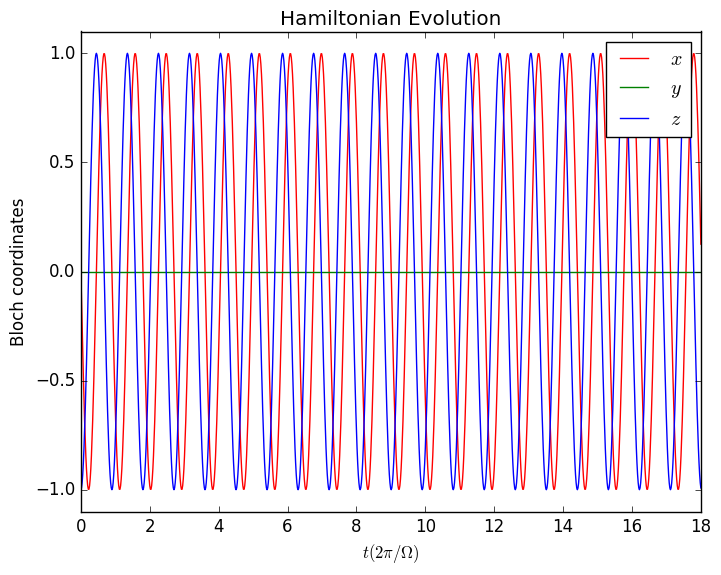

  0.106620 seconds (205.44 k allocations: 12.212 MB, 8.67% gc time)


INFO: Trajectory: steps = 1799, points = 1000, values = 3
INFO: Time elapsed: 0.014279135 s, Steps per second: 125988.02378435388


In [6]:
solve(ham(dt, H), init, dt, T, fs, "Hamiltonian Evolution")

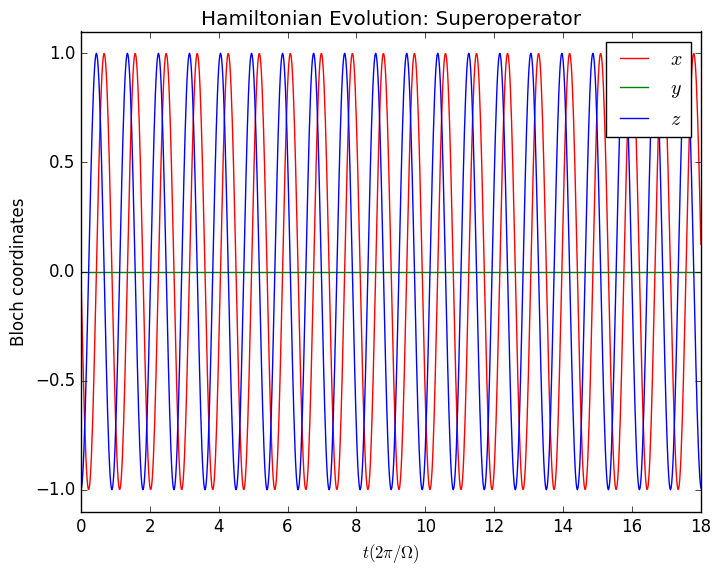

  0.057507 seconds (128.75 k allocations: 7.948 MB)


INFO: Trajectory: steps = 1799, points = 1000, values = 3
INFO: Time elapsed: 0.056899917 s, Steps per second: 31616.917824326527


In [7]:
solve(sham(dt, H), sinit, dt, T, sfs, "Hamiltonian Evolution: Superoperator")

### Dissipative (Lindblad) Evolution

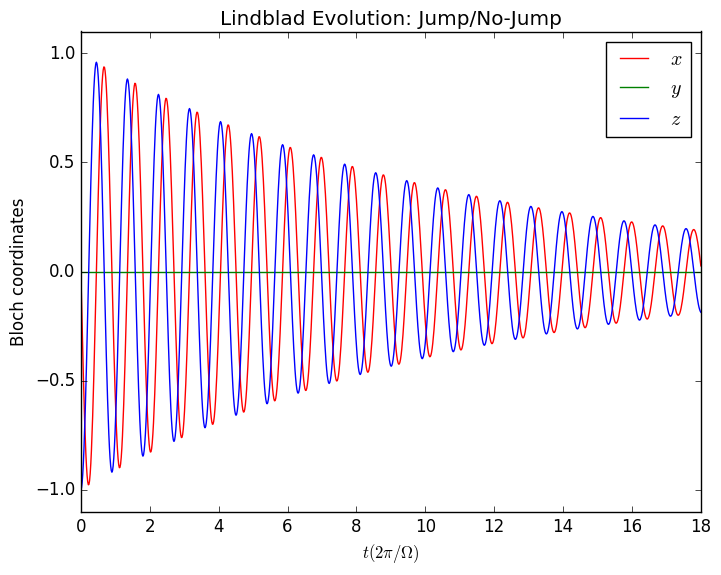

  0.058703 seconds (277.69 k allocations: 21.219 MB, 8.95% gc time)


INFO: Trajectory: steps = 1799, points = 1000, values = 3
INFO: Time elapsed: 0.058106454 s, Steps per second: 30960.416204368623


In [8]:
solve(lind(dt, H, DM), init, dt, T, fs, "Lindblad Evolution: Jump/No-Jump")

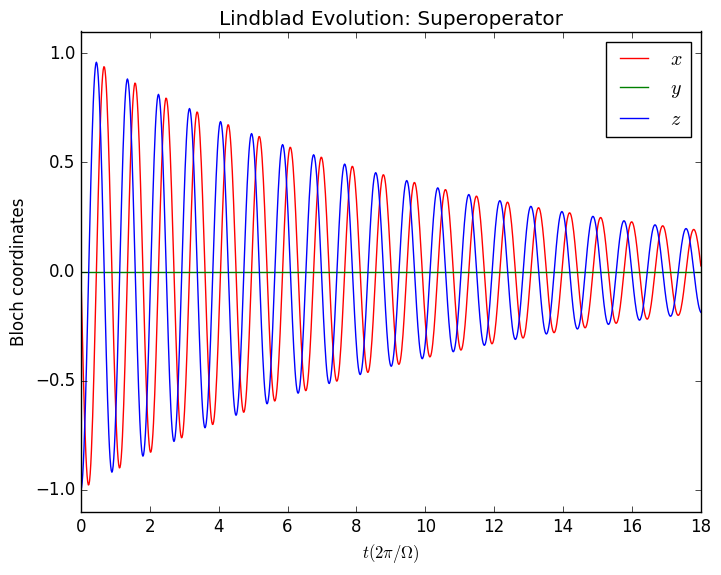

  0.071193 seconds (128.81 k allocations: 7.952 MB)


INFO: Trajectory: steps = 1799, points = 1000, values = 3
INFO: Time elapsed: 0.0705237 s, Steps per second: 25509.15507836373


In [9]:
solve(slind(dt, H, DM), sinit, dt, T, sfs, "Lindblad Evolution: Superoperator")

INFO: Trajectory: steps = 1799, points = 1000, values = 3
INFO: Time elapsed: 0.751576483 s, Steps per second: 2393.635299522803


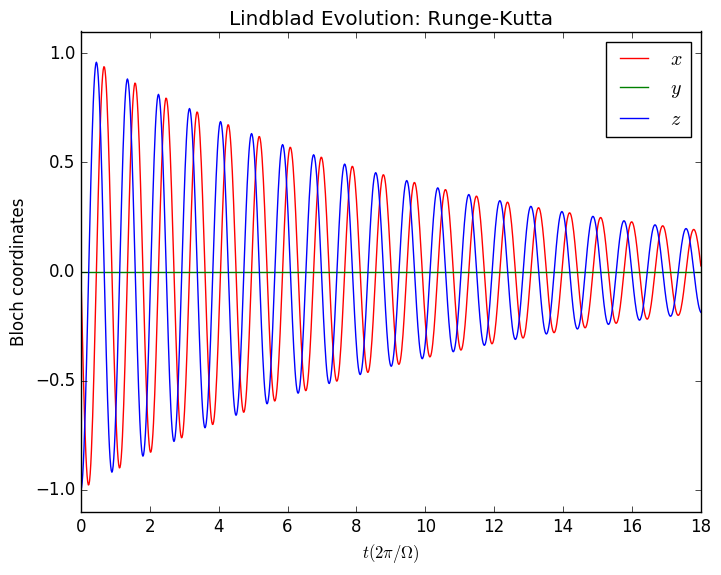

  0.752621 seconds (2.60 M allocations: 179.282 MB, 4.14% gc time)


In [10]:
solve(lind_rk4(dt, H, DM), init, dt, T, fs, "Lindblad Evolution: Runge-Kutta")

### Stochastic (Monitored) Evolution

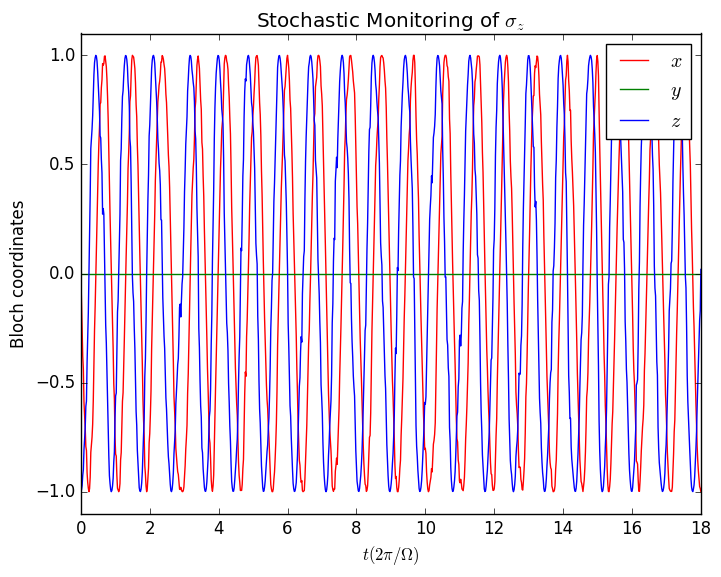

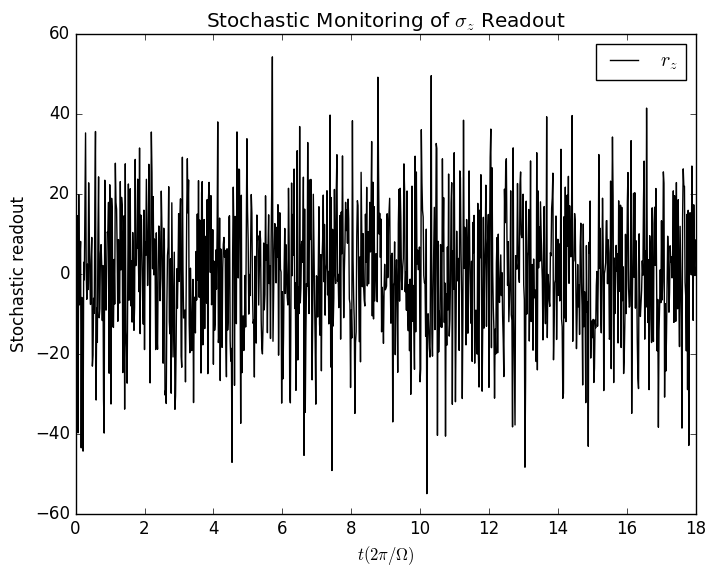

  0.076520 seconds (359.78 k allocations: 27.580 MB, 8.18% gc time)


INFO: Trajectory: steps = 1799, points = 1000, values = 3
INFO: Readout: values = 1
INFO: Time elapsed: 0.075216548 s, Steps per second: 23917.609194189557


In [11]:
solve(meas(dt, H, SM), init, dt, T, fs, L"Stochastic Monitoring of $\sigma_z$", readout=true)

(Note: no parallelization performed here to benchmark serial execution of an ensemble simulation. Plotted is the mean with shaded standard deviation behind.)

INFO: Trajectories: 2500, steps each: 1799, points each: 1000, values each = 3
INFO: Readouts: values each = 1


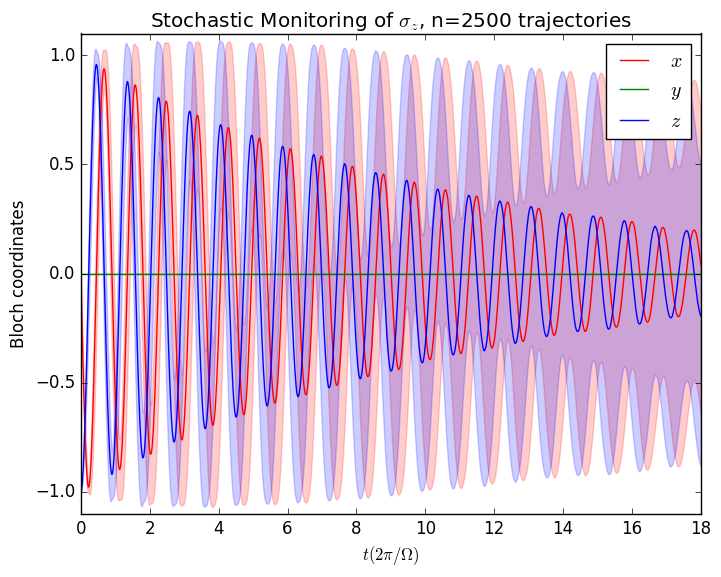

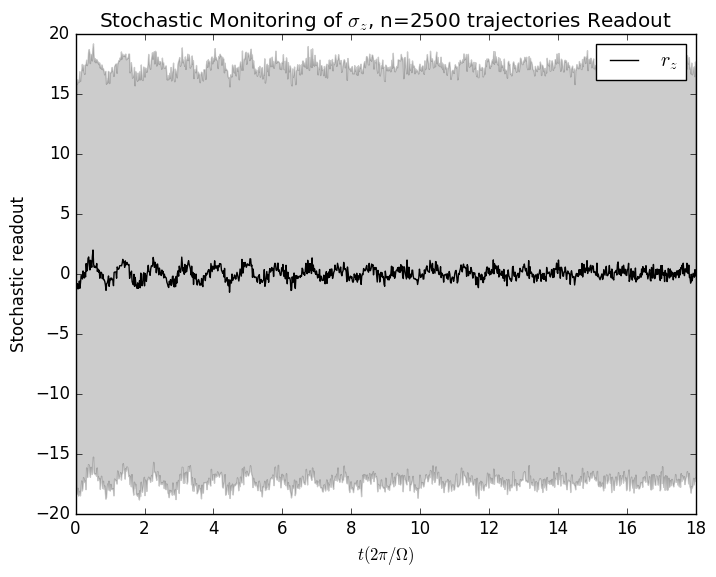

182.611431 seconds (898.89 M allocations: 67.185 GB, 5.43% gc time)


INFO: Time elapsed: 182.460232975 s, Steps: 2500000, Steps per second: 13701.615739702253


In [12]:
solve(meas(dt, H, SM), init, dt, T, fs, L"Stochastic Monitoring of $\sigma_z$, n=2500 trajectories", readout=true, n=2500)

## Time-dependent Rabi Pulse

In [13]:
# Hamiltonian
f(t::Float64) = 2*exp(-(t-3*τ)^2/2)/sqrt(2π)
h(t::Float64) = f(t)*(Ω/2)*q("y");

### Coherent (Hamiltonian) Evolution

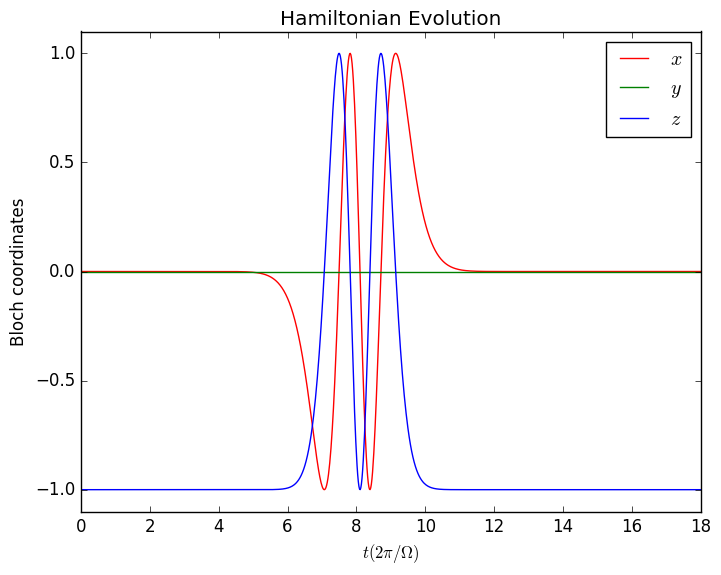

  0.039247 seconds (265.35 k allocations: 18.762 MB, 10.55% gc time)


INFO: Trajectory: steps = 1799, points = 1000, values = 3
INFO: Time elapsed: 0.038744008 s, Steps per second: 46432.986489162395


In [14]:
solve(ham(dt, h), init, dt, T, fs, "Hamiltonian Evolution")

INFO: Trajectory: steps = 1799, points = 1000, values = 3
INFO: Time elapsed: 0.1680801 s, Steps per second: 10703.230186083896


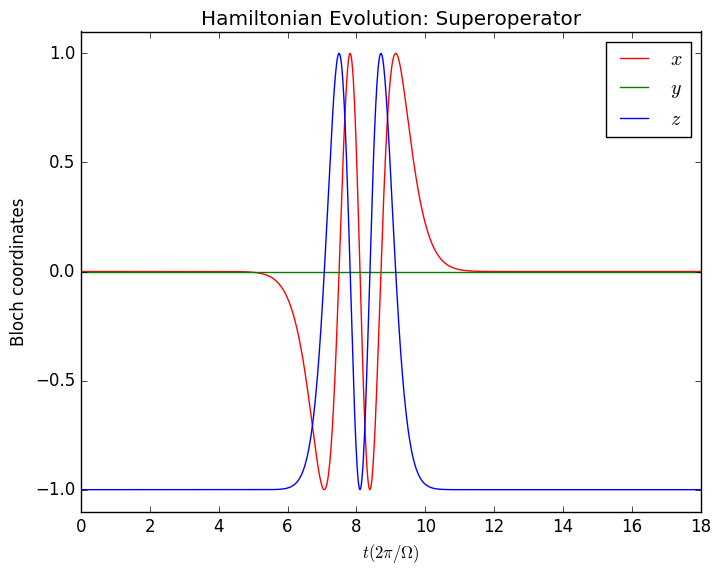

  0.168734 seconds (414.02 k allocations: 29.515 MB, 2.96% gc time)


In [15]:
solve(sham(dt, h), sinit, dt, T, sfs, "Hamiltonian Evolution: Superoperator")

### Dissipative (Lindblad) Evolution

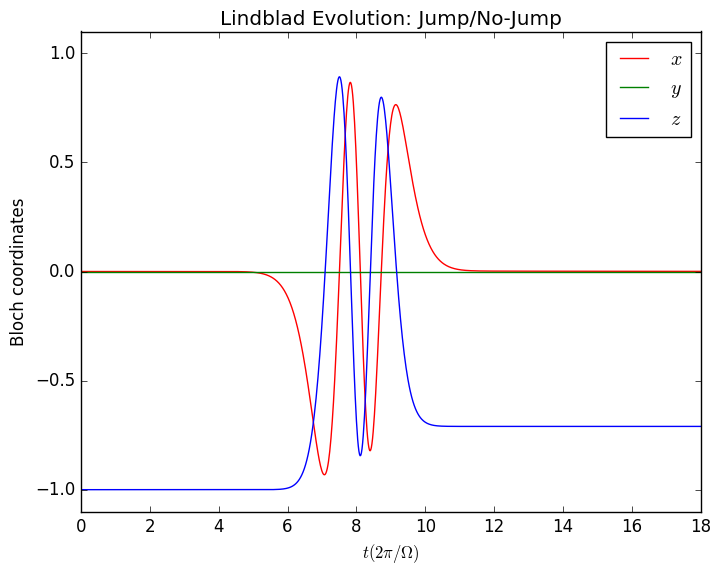

  0.089680 seconds (431.30 k allocations: 31.928 MB, 9.74% gc time)


INFO: Trajectory: steps = 1799, points = 1000, values = 3
INFO: Time elapsed: 0.089124093 s, Steps per second: 20185.338660332847


In [16]:
solve(lind(dt, h, DM), init, dt, T, fs, "Lindblad Evolution: Jump/No-Jump")

INFO: Trajectory: steps = 1799, points = 1000, values = 3
INFO: Time elapsed: 0.395573085 s, Steps per second: 4547.832166083797


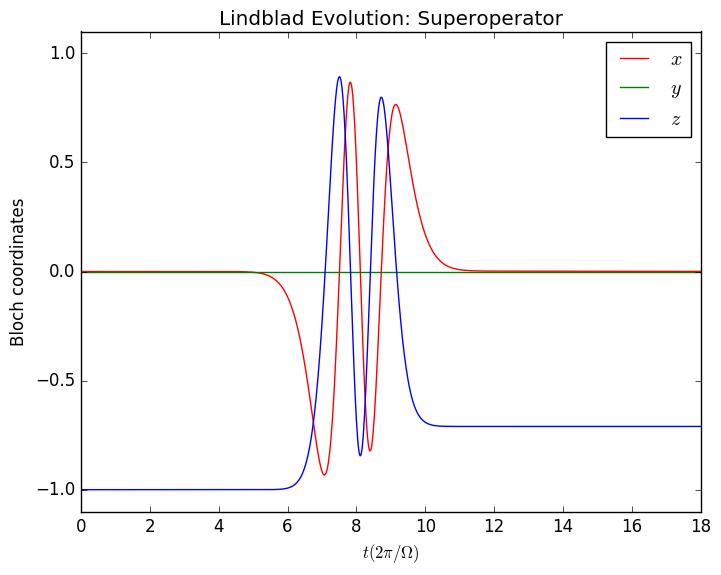

  0.396504 seconds (912.71 k allocations: 70.911 MB, 3.93% gc time)


In [17]:
solve(slind(dt, h, DM), sinit, dt, T, sfs, "Lindblad Evolution: Superoperator")

INFO: Trajectory: steps = 1799, points = 1000, values = 3
INFO: Time elapsed: 0.825830664 s, Steps per second: 2178.4126921206207


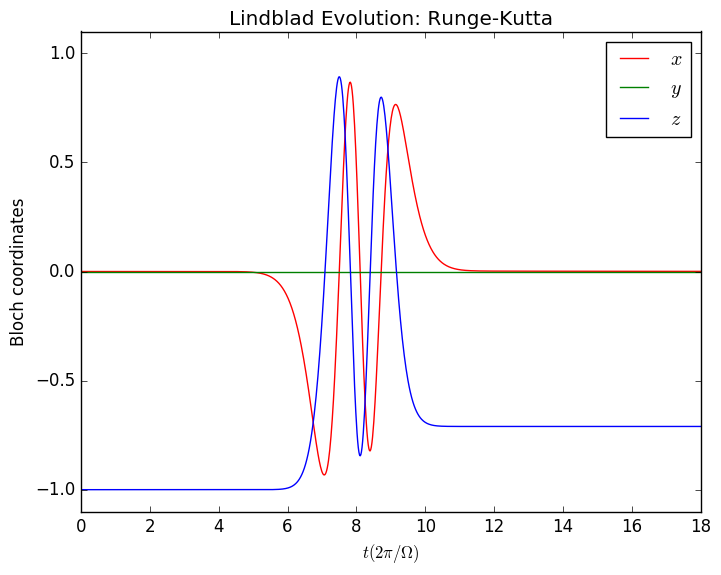

  0.826873 seconds (2.73 M allocations: 183.681 MB, 3.88% gc time)


In [18]:
solve(lind_rk4(dt, h, DM), init, dt, T, fs, "Lindblad Evolution: Runge-Kutta")

### Stochastic (Monitored) Evolution

INFO: Trajectory: steps = 1799, points = 1000, values = 3
INFO: Readout: values = 1


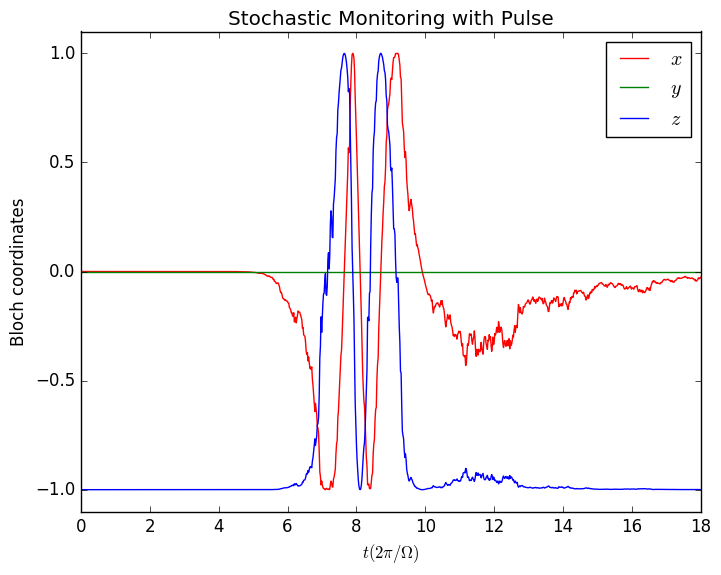

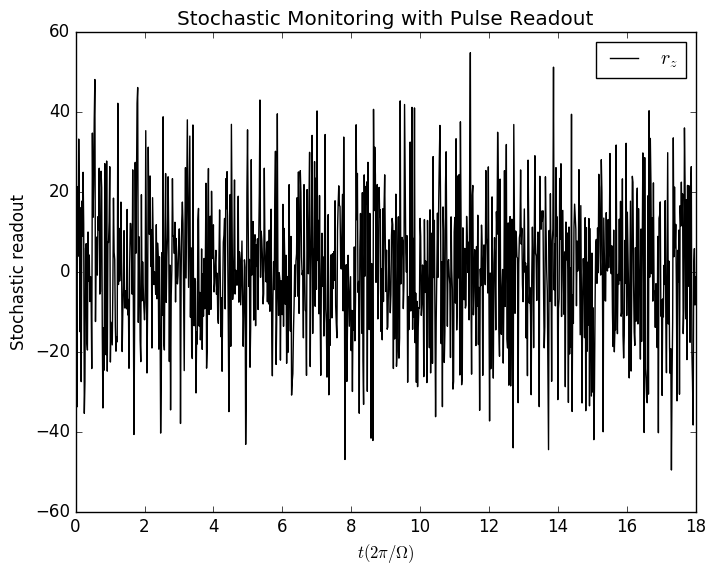

  0.164206 seconds (513.43 k allocations: 38.258 MB, 6.50% gc time)


INFO: Time elapsed: 0.162490897 s, Steps per second: 11071.389432972359


In [19]:
solve(meas(dt, h, SM), init, dt, T, fs, "Stochastic Monitoring with Pulse", readout=true)

INFO: Trajectories: 2500, steps each: 1799, points each: 1000, values each = 3
INFO: Readouts: values each = 1


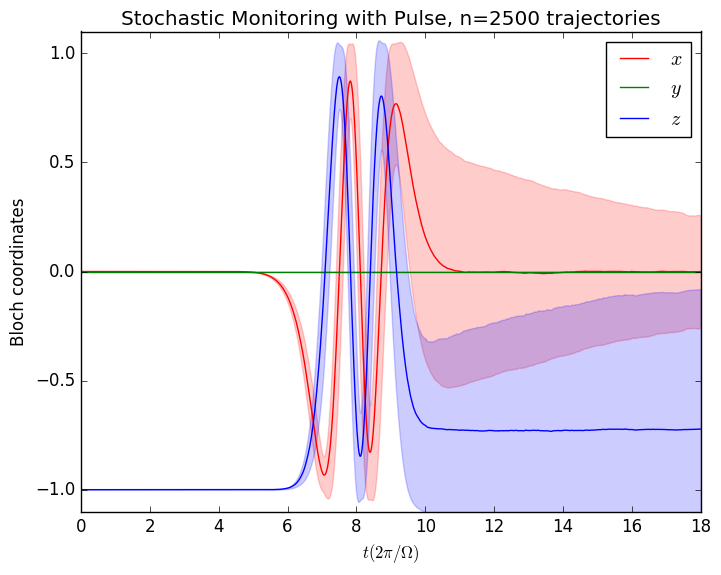

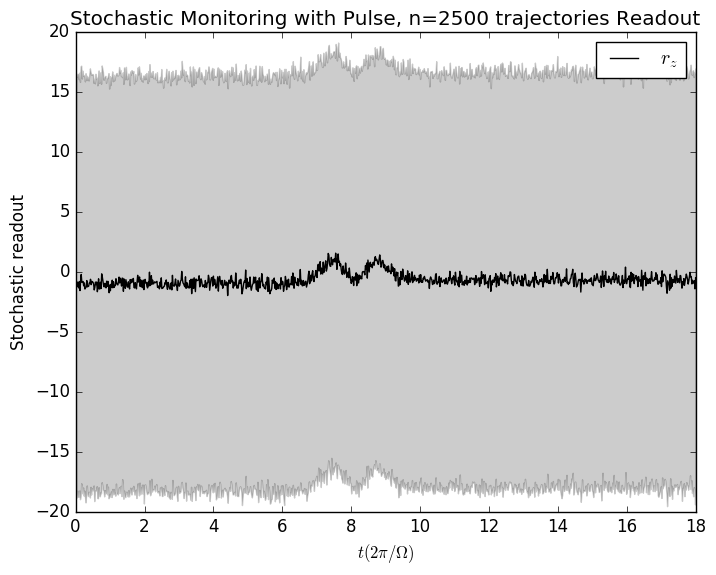

262.731823 seconds (1.28 G allocations: 93.266 GB, 4.95% gc time)


INFO: Time elapsed: 262.68186513 s, Steps: 2500000, Steps per second: 9517.21581070228


In [20]:
solve(meas(dt, h, SM), init, dt, T, fs, "Stochastic Monitoring with Pulse, n=2500 trajectories", readout=true, n=2500)

## Version Information

In [21]:
versioninfo()

Julia Version 0.5.0
Commit 3c9d753 (2016-09-19 18:14 UTC)
Platform Info:
  System: Linux (x86_64-linux-gnu)
  CPU: Intel(R) Core(TM) i7-6560U CPU @ 2.20GHz
  WORD_SIZE: 64
  BLAS: libopenblas (NO_LAPACKE DYNAMIC_ARCH NO_AFFINITY Haswell)
  LAPACK: liblapack.so.3
  LIBM: libopenlibm
  LLVM: libLLVM-3.7.1 (ORCJIT, broadwell)


In [22]:
Pkg.installed("PyPlot")

v"2.2.4"

In [23]:
Pkg.installed("Interpolations")

v"0.3.6"

In [24]:
Pkg.installed("QuantumBayesian")

v"0.0.0-"